# Introductino to SINDy

Sparse Identification of Nonlinear Dynamics (SINDy) is a data driven methods of discovering governing equation from a dynamical time series data. It was introduced by Brunton et al. in 2016 to identify sparse and interpretable models from the data. We assume that the data dynamics are expressed as linear combination of a library of candidate functions and use sparse regression to select only relevant terms.  

$$\bold{\dot{x}} = \bold{\Theta}(\bold{x}) \bold{\xi}$$
where $\mathbf{\Theta}(\mathbf{x})$ is a matrix of candidate functions evaluated on the state $\mathbf{x}$, and $\boldsymbol{\xi}$ is a sparse coefficient vector found via optimization.

## Step 1: Generate Synthetic Data
We simulate the PDE using finite differences on a 1D domain $[0, 2]$ with 1001 spatial points and 2000 time steps ($\Delta t = 0.001$).
For the heat equation (linear diffusion):

Initial condition: Gaussian bump $u(x,0) = e^{-(x - 1)^2}$

For Burgers' equation (nonlinear advection-diffusion):

Initial condition: Sine wave $u(x,0) = \sin(2\pi x / 2)$

Code for data generation (heat equation example):
The heat (diffusion) equation: $u_t = 0.1 u_{xx}$
$$(u_{t+1,x}-u_{t,x})/dt = 0.1(u_{t,x}-2u_{t,x-1}+u_{t,x-2})/(dx)^2$$

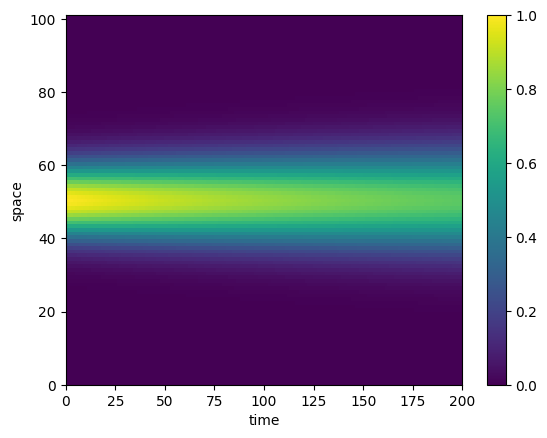

In [8]:
import numpy as np

# Parameters
L = 10  # Domain length
nx = 101  # Spatial points
dx = L / (nx - 1)
nt = 200  # Time points
dt = 0.01  # Time step
alpha = 0.1  # Diffusion coefficient

# Initial condition
x = np.linspace(0, L, nx)
u0 = np.exp(- (x - L/2)**2 )

# Simulate
u = np.zeros((nt, nx))
u[0] = u0
for n in range(1, nt):
    u[n, 1:-1] = u[n-1, 1:-1] + alpha * dt / dx**2 * (u[n-1, 2:] - 2*u[n-1, 1:-1] + u[n-1, :-2])

u = u.T  # Shape: (nx, nt)

import matplotlib.pyplot as plt 
a = plt.pcolor(u)
plt.colorbar(a)
plt.xlabel("time")
plt.ylabel("space")
plt.show()

## Computing derivatives 

In [9]:
u_t = np.gradient(u,dt,axis=1) # ∂u/∂t
u_x = np.gradient(u,dx,axis=0) # ∂u/∂x
u_xx = np.gradient(u_x,dx,axis=0) # ∂²u/∂x²

# FOcusing on interior points to reduce boundary errors .
ix = slice(2,-2) # Skip edge in space
it = slice(1,-1) # Skip edge in time 
Ut = u_t[ix,it].flatten()
Ux = u_x[ix,it].flatten()
Uxx = u_xx[ix,it].flatten()

U = u[ix,it].flatten() # State 

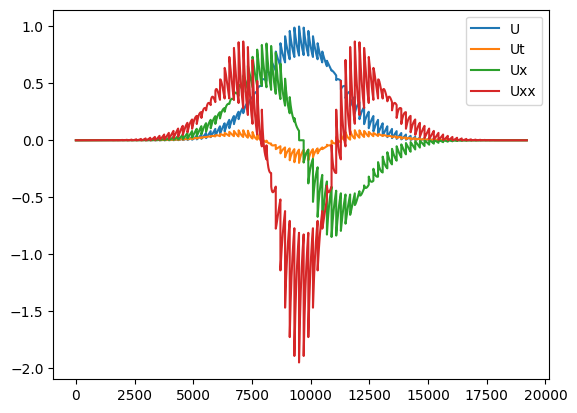

In [11]:
plt.plot(U, label="U")
plt.plot(Ut, label="Ut")
plt.plot(Ux, label="Ux")
plt.plot(Uxx,label="Uxx")
plt.legend()
plt.show()

## Build the library matrix $\Theta$
Selected candidate terms : $1, u, u², u_x, u u_x, u² u_x, u_xx, u u_xx, u² u_xx$

In [12]:
ones = np.ones_like(U)
Theta = np.vstack([ones, U, U**2, Ux, U * Ux, U**2 * Ux, Uxx, U * Uxx, U**2 * Uxx]).T
# Shape: (num_points, num_terms)


## Step 4: Sparse Regression with STLSQ
Solve $\mathbf{U_t} = \mathbf{\Theta} \boldsymbol{\xi}$ using sequential thresholded least squares:

- Start with ordinary least squares.
- Threshold small coefficients to zero.
- Refit on remaining terms.
- Repeat for a few iterations.

In [14]:
from scipy.linalg import lstsq

def stlsq(Theta, Ut, threshold=0.05, iterations=20):
    xi = lstsq(Theta, Ut)[0]
    for _ in range(iterations):
        small_inds = np.abs(xi) < threshold
        xi[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        xi[big_inds] = lstsq(Theta[:, big_inds], Ut)[0]
    return xi

## Apply STLSQ and print non-zero coefficients.
For the heat equation (using a linear-restricted library for better sparsity):
This recovers $u_t \approx 0.1 u_{xx}$, matching the true PDE.

In [16]:
Theta_linear = np.vstack([ones,U,Ux,Uxx]).T 
xi = stlsq(Theta_linear,Ut,threshold=0.005,iterations=100)
# Features: ['1', 'u', 'u_x', 'u_xx']
# Recovered: u_xx: 0.1012 (close to 0.1; slight error from numerical differentiation)

In [18]:
print(xi.shape)
print(xi)

(4,)
[0.         0.         0.         0.10118168]
